# Notebook for predicting Pitcher WAR from features via simple linear regression


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler


In [14]:
# Load the by-year data (using retry files with fixed WAR merging)
data_yr = pd.read_csv("data/Pitchers_2015-2025_byYear_retry.csv")
print(f"Total rows: {len(data_yr)}")
print(f"Years available: {sorted(data_yr['year'].dropna().unique())}")
print(f"Players with 2025 data: {len(data_yr[data_yr['year'] == 2025]['mlbID'].unique())}")
print(f"Rows with WAR: {data_yr['WAR'].notna().sum()} / {len(data_yr)} ({data_yr['WAR'].notna().sum()/len(data_yr)*100:.1f}%)")
data_yr.head()


Total rows: 8968
Years available: [2015.0, 2016.0, 2017.0, 2018.0, 2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025.0]
Players with 2025 data: 349
Rows with WAR: 8034 / 8968 (89.6%)


,Name,Age,#days,Lev,Tm,G,GS,W,L,SV,...,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff,Season,WAR
0,David Aardsma,33,3752,Maj-NL,Atlanta,33,0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,-0.13
1,Fernando Abad,29,3711,Maj-AL,Oakland,62,0,2.0,2.0,NaN,...,0.425,0.067,0.342,0.311,0.031,4.15,4.02,0.134,2015,0.18
2,A.J. Achter,26,3710,Maj-AL,Minnesota,11,0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,-0.18
3,Austin Adams,28,3714,Maj-AL,Cleveland,28,0,2.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,0.30
4,Nathan Adcock,27,3780,Maj-NL,Cincinnati,13,0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,-0.22


In [15]:
# Separate data into 2023-2024 (features) and 2025 (target)
data_2023_2024 = data_yr[data_yr['year'].isin([2023, 2024])].copy()
data_2025 = data_yr[data_yr['year'] == 2025].copy()

print(f"2023-2024 rows: {len(data_2023_2024)}")
print(f"2025 rows: {len(data_2025)}")
print(f"Unique players in 2023-2024: {data_2023_2024['mlbID'].nunique()}")
print(f"Unique players in 2025: {data_2025['mlbID'].nunique()}")

# Find players who have both 2023-2024 and 2025 data
players_with_2025 = set(data_2025['mlbID'].unique())
players_with_2023_2024 = set(data_2023_2024['mlbID'].unique())
common_players = players_with_2025.intersection(players_with_2023_2024)
print(f"Players with both 2023-2024 and 2025 data: {len(common_players)}")


2023-2024 rows: 738
2025 rows: 349
Unique players in 2023-2024: 512
Unique players in 2025: 349
Players with both 2023-2024 and 2025 data: 257


In [16]:
# Identify feature columns (exclude identifiers, year, and target)
exclude_cols = ['Name', 'mlbID', 'year', 'Season', 'WAR', 'Name_ev', 'Name_x', 
                'Lev', 'Tm', 'team', 'position', 'team_id']

# Get numeric columns that could be features
numeric_cols = data_2023_2024.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols and col != 'WAR']

print(f"Number of potential features: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:10]}")


Number of potential features: 67
Sample features: ['Age', '#days', 'G', 'GS', 'W', 'L', 'SV', 'IP', 'H', 'R']


In [17]:
# For each player, average their 2023-2024 features (handling NaN appropriately)
# We'll average numeric features, but need to be careful about which ones to average vs sum

def average_features_by_player(df, player_id_col='mlbID', feature_cols=None):
    """
    Average features across years for each player.
    Handles NaN by only averaging non-NaN values.
    """
    if feature_cols is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        exclude_cols = ['year', 'Season', 'WAR']
        feature_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    # Group by player and average (NaN values are ignored in mean calculation)
    averaged = df.groupby(player_id_col)[feature_cols].mean().reset_index()
    
    # Also get player name for reference
    if 'Name' in df.columns:
        name_map = df.groupby(player_id_col)['Name'].first().reset_index()
        averaged = averaged.merge(name_map, on=player_id_col, how='left')
    
    return averaged

# Average 2023-2024 features for each player (for training)
features_avg_train = average_features_by_player(data_2023_2024, feature_cols=feature_cols)
print(f"Training features shape (2023-2024 averaged): {features_avg_train.shape}")

# Also average 2023-2024 features for players who have 2025 data (for prediction)
# This will be the same as features_avg_train, but we'll use it for consistency
features_avg = features_avg_train.copy()
print(f"Prediction features shape: {features_avg.shape}")
features_avg.head()


Training features shape (2023-2024 averaged): (512, 69)
Prediction features shape: (512, 69)


,mlbID,Age,#days,G,GS,W,L,SV,IP,H,...,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff,Name
0,425794,41.0,804.0,21.0,21.0,5.0,11.0,NaN,101.00,151.0,...,0.5730,0.562,0.0110,0.4140,0.401,0.0130,7.40,7.350,0.046,Adam Wainwright
1,425844,39.0,791.0,30.0,27.0,2.0,15.0,NaN,142.10,158.0,...,0.4670,0.479,-0.0120,0.3320,0.343,-0.0110,5.06,5.060,-0.001,Zack Greinke
2,434378,40.5,600.0,23.5,23.5,9.5,7.5,NaN,135.15,126.5,...,0.4095,0.390,0.0195,0.3105,0.298,0.0125,4.35,3.705,0.643,Justin Verlander
3,445276,36.0,434.0,54.0,0.0,4.0,2.0,27.0,54.20,38.0,...,0.3040,0.352,-0.0480,0.2530,0.280,-0.0270,3.29,3.240,0.053,Kenley Jansen
4,445926,40.0,425.0,47.0,0.0,2.0,2.0,NaN,65.10,60.0,...,0.4270,0.409,0.0180,0.3150,0.317,-0.0020,3.13,4.220,-1.094,Jesse Chavez


In [18]:
# Prepare training data: 2023-2024 features -> 2023-2024 WAR per 162
# For each player in 2023-2024, calculate their WAR per 162
data_2023_2024_with_war = data_2023_2024.copy()
data_2023_2024_with_war['WAR_per_162'] = (data_2023_2024_with_war['WAR'] / data_2023_2024_with_war['G'].replace(0, pd.NA)) * 162

# Average WAR per 162 across 2023-2024 for each player (for training target)
war_per_162_train = data_2023_2024_with_war.groupby('mlbID')['WAR_per_162'].mean().reset_index()
war_per_162_train.columns = ['mlbID', 'WAR_per_162_train']

# Merge training features with training target
train_data = features_avg_train.merge(war_per_162_train, on='mlbID', how='inner')

print("Training Data (2023-2024):")
print(f"Shape: {train_data.shape}")
print(f"Players: {len(train_data)}")
print(f"\nWAR_per_162 (2023-2024 averaged) stats:")
print(train_data['WAR_per_162_train'].describe())
print(f"\nNaN in training target: {train_data['WAR_per_162_train'].isna().sum()}")

# Prepare test data: 2023-2024 features -> 2025 WAR per 162
# Ensure we have all required columns from data_2025
required_cols = ['mlbID', 'WAR', 'G', 'Name']
# Check which columns actually exist
available_cols = [col for col in required_cols if col in data_2025.columns]
target_2025 = data_2025[available_cols].copy()

# Calculate WAR per 162 games (handle division by zero)
if 'G' in target_2025.columns and 'WAR' in target_2025.columns:
    target_2025['WAR_per_162_2025'] = (target_2025['WAR'] / target_2025['G'].replace(0, pd.NA)) * 162
else:
    raise ValueError("Required columns 'G' or 'WAR' not found in data_2025")

# Merge features with 2025 target (for evaluation)
# Don't include 'G' from target_2025 since features_avg already has 'G' (from 2023-2024)
# We only need WAR_per_162_2025 and WAR for evaluation
merge_cols = ['mlbID', 'WAR_per_162_2025', 'WAR']
test_data = features_avg.merge(target_2025[merge_cols], on='mlbID', how='inner')

print("\nTest Data (2025):")
print(f"Shape: {test_data.shape}")
print(f"Players: {len(test_data)}")
print(f"\nWAR_per_162_2025 stats:")
print(test_data['WAR_per_162_2025'].describe())
print(f"\nNaN in test target: {test_data['WAR_per_162_2025'].isna().sum()}")

train_data.head()


Training Data (2023-2024):
Shape: (512, 70)
Players: 512

WAR_per_162 (2023-2024 averaged) stats:
count    464.000000
mean       4.832416
std        7.399017
min      -15.390000
25%        0.719037
50%        3.220640
75%        7.855159
max       41.345217
Name: WAR_per_162_train, dtype: float64

NaN in training target: 48

Test Data (2025):
Shape: (257, 71)
Players: 257

WAR_per_162_2025 stats:
count    234.000000
mean       6.014960
std        9.634297
min      -24.300000
25%        0.755693
50%        3.427959
75%        8.813710
max       49.410000
Name: WAR_per_162_2025, dtype: float64

NaN in test target: 23


,mlbID,Age,#days,G,GS,W,L,SV,IP,H,...,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,era,xera,era_minus_xera_diff,Name,WAR_per_162_train
0,425794,41.0,804.0,21.0,21.0,5.0,11.0,NaN,101.00,151.0,...,0.562,0.0110,0.4140,0.401,0.0130,7.40,7.350,0.046,Adam Wainwright,-14.580000
1,425844,39.0,791.0,30.0,27.0,2.0,15.0,NaN,142.10,158.0,...,0.479,-0.0120,0.3320,0.343,-0.0110,5.06,5.060,-0.001,Zack Greinke,5.886000
2,434378,40.5,600.0,23.5,23.5,9.5,7.5,NaN,135.15,126.5,...,0.390,0.0195,0.3105,0.298,0.0125,4.35,3.705,0.643,Justin Verlander,7.769647
3,445276,36.0,434.0,54.0,0.0,4.0,2.0,27.0,54.20,38.0,...,0.352,-0.0480,0.2530,0.280,-0.0270,3.29,3.240,0.053,Kenley Jansen,3.960000
4,445926,40.0,425.0,47.0,0.0,2.0,2.0,NaN,65.10,60.0,...,0.409,0.0180,0.3150,0.317,-0.0020,3.13,4.220,-1.094,Jesse Chavez,2.171489


In [19]:
# Prepare training features and target (2023-2024)
train_data_clean = train_data.dropna(subset=['WAR_per_162_train']).copy()
# Only select feature columns that actually exist in the dataframe
available_train_features = [col for col in feature_cols if col in train_data_clean.columns]
X_train_full = train_data_clean[available_train_features].copy()
y_train_full = train_data_clean['WAR_per_162_train'].copy()

# Prepare test features and target (2025)
test_data_clean = test_data.dropna(subset=['WAR_per_162_2025']).copy()

# Debug: Check which feature columns are missing
missing_features = [col for col in feature_cols if col not in test_data_clean.columns]
if missing_features:
    print(f"Warning: {len(missing_features)} features missing from test_data: {missing_features[:10]}")

# Only select feature columns that actually exist in the dataframe
available_test_features = [col for col in feature_cols if col in test_data_clean.columns]
X_test = test_data_clean[available_test_features].copy()
y_test = test_data_clean['WAR_per_162_2025'].copy()

# Ensure both have the same features (use intersection)
common_features = list(set(available_train_features) & set(available_test_features))
X_train_full = X_train_full[common_features].copy()
X_test = X_test[common_features].copy()

print(f"Training set: {X_train_full.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Common features used: {len(common_features)}")
if len(common_features) < len(feature_cols):
    missing = set(feature_cols) - set(common_features)
    print(f"Features excluded (not in both datasets): {missing}")

# Handle NaN in features - we'll use median imputation for missing values
from sklearn.impute import SimpleImputer

# Fit imputer on training data
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_full),
    columns=X_train_full.columns,
    index=X_train_full.index
)

# Transform test data with the same imputer
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print(f"\nTraining NaN after imputation: {X_train_imputed.isna().sum().sum()}")
print(f"Test NaN after imputation: {X_test_imputed.isna().sum().sum()}")

# Scale features (important for regularization)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

# For consistency with variable names in later cells
# Use scaled features for regularized models, original for comparison
X_train = X_train_scaled
y_train = y_train_full
X_test = X_test_scaled
X_train_unscaled = X_train_imputed  # Keep unscaled for LinearRegression comparison
X_test_unscaled = X_test_imputed


Training set: 464 samples
Test set: 234 samples
Common features used: 67

Training NaN after imputation: 0
Test NaN after imputation: 0


In [20]:
# Train models with regularization on 2023-2024 data
# Model learns: 2023-2024 features -> 2023-2024 WAR per 162
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Baseline: Linear Regression (no regularization) - use unscaled data
lr_model = LinearRegression()
lr_model.fit(X_train_unscaled, y_train)
y_train_pred_lr = lr_model.predict(X_train_unscaled)
y_test_pred_lr = lr_model.predict(X_test_unscaled)

# Ridge Regression (L2 regularization)
print("Tuning Ridge Regression...")
ridge_param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_train)
ridge_model = ridge_grid.best_estimator_
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)
print(f"Best Ridge alpha: {ridge_grid.best_params_['alpha']}")

# Lasso Regression (L1 regularization)
print("Tuning Lasso Regression...")
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
lasso_grid = GridSearchCV(Lasso(max_iter=10000), lasso_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_grid.fit(X_train, y_train)
lasso_model = lasso_grid.best_estimator_
y_train_pred_lasso = lasso_model.predict(X_train)
y_test_pred_lasso = lasso_model.predict(X_test)
print(f"Best Lasso alpha: {lasso_grid.best_params_['alpha']}")

# ElasticNet (L1 + L2 regularization)
print("Tuning ElasticNet...")
elasticnet_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elasticnet_grid = GridSearchCV(ElasticNet(max_iter=10000), elasticnet_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
elasticnet_grid.fit(X_train, y_train)
elasticnet_model = elasticnet_grid.best_estimator_
y_train_pred_elasticnet = elasticnet_model.predict(X_train)
y_test_pred_elasticnet = elasticnet_model.predict(X_test)
print(f"Best ElasticNet alpha: {elasticnet_grid.best_params_['alpha']}, l1_ratio: {elasticnet_grid.best_params_['l1_ratio']}")

# Calculate metrics for all models
models = {
    'Linear Regression': (y_train_pred_lr, y_test_pred_lr),
    'Ridge': (y_train_pred_ridge, y_test_pred_ridge),
    'Lasso': (y_train_pred_lasso, y_test_pred_lasso),
    'ElasticNet': (y_train_pred_elasticnet, y_test_pred_elasticnet)
}

print("\n" + "="*70)
print("Model Performance Comparison:")
print("="*70)

results = []
for name, (y_train_pred, y_test_pred) in models.items():
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'Model': name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2
    })
    
    print(f"\n{name}:")
    print(f"  Training: RMSE={train_rmse:.3f}, MAE={train_mae:.3f}, R²={train_r2:.3f}")
    print(f"  Test:     RMSE={test_rmse:.3f}, MAE={test_mae:.3f}, R²={test_r2:.3f}")

# Select best model based on test RMSE
results_df = pd.DataFrame(results)
best_model_name = results_df.loc[results_df['Test_RMSE'].idxmin(), 'Model']
print(f"\n{'='*70}")
print(f"Best model (lowest test RMSE): {best_model_name}")
print(f"{'='*70}")

# Store best model predictions for later use
if best_model_name == 'Linear Regression':
    best_model = lr_model
    y_train_pred = y_train_pred_lr
    y_test_pred = y_test_pred_lr
elif best_model_name == 'Ridge':
    best_model = ridge_model
    y_train_pred = y_train_pred_ridge
    y_test_pred = y_test_pred_ridge
elif best_model_name == 'Lasso':
    best_model = lasso_model
    y_train_pred = y_train_pred_lasso
    y_test_pred = y_test_pred_lasso
else:  # ElasticNet
    best_model = elasticnet_model
    y_train_pred = y_train_pred_elasticnet
    y_test_pred = y_test_pred_elasticnet

# Also keep lr_model for backward compatibility
lr_model = best_model


Tuning Ridge Regression...
Best Ridge alpha: 1.0
Tuning Lasso Regression...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e+02, tolerance: 2.014e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.461e+02, tolerance: 2.020e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Best Lasso alpha: 0.1
Tuning ElasticNet...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.791e+02, tolerance: 2.014e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.630e+02, tolerance: 1.905e+00
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Best ElasticNet alpha: 0.01, l1_ratio: 0.9

Model Performance Comparison:

Linear Regression:
  Training: RMSE=2.969, MAE=2.111, R²=0.839
  Test:     RMSE=9.250, MAE=6.769, R²=0.074

Ridge:
  Training: RMSE=3.029, MAE=2.166, R²=0.832
  Test:     RMSE=9.193, MAE=6.735, R²=0.086

Lasso:
  Training: RMSE=3.280, MAE=2.337, R²=0.803
  Test:     RMSE=9.070, MAE=6.644, R²=0.110

ElasticNet:
  Training: RMSE=3.062, MAE=2.186, R²=0.828
  Test:     RMSE=9.185, MAE=6.743, R²=0.087

Best model (lowest test RMSE): Lasso


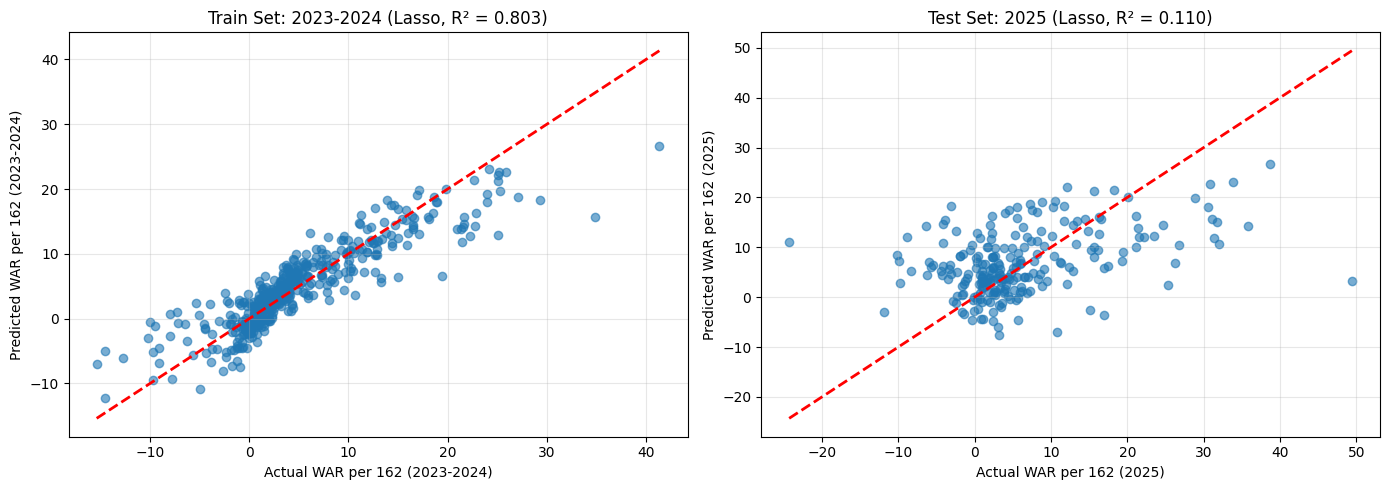

In [21]:
# Visualize predictions vs actual (using best model)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set (2023-2024)
axes[0].scatter(y_train, y_train_pred, alpha=0.6)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual WAR per 162 (2023-2024)')
axes[0].set_ylabel('Predicted WAR per 162 (2023-2024)')
axes[0].set_title(f'Train Set: 2023-2024 ({best_model_name}, R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set (2025)
axes[1].scatter(y_test, y_test_pred, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual WAR per 162 (2025)')
axes[1].set_ylabel('Predicted WAR per 162 (2025)')
axes[1].set_title(f'Test Set: 2025 ({best_model_name}, R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [22]:
# Get feature importance (coefficients) from best model
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_model.coef_
})
feature_importance['abs_coefficient'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print(f"Top 20 Most Important Features (by absolute coefficient) - {best_model_name}:")
print(feature_importance.head(20))


Top 20 Most Important Features (by absolute coefficient) - Lasso:
                   feature  coefficient  abs_coefficient
11                       R    -6.481045         6.481045
54                      pa     3.714125         3.714125
50                      IP     3.523264         3.523264
64                       G    -2.551016         2.551016
37                     era    -1.506765         1.506765
22                    xera    -1.256153         1.256153
0                       SO     1.050472         1.050472
43                     GDP     0.687803         0.687803
66                      PO     0.281566         0.281566
61                      PU     0.270933         0.270933
31                   #days     0.246615         0.246615
12                    fbld     0.219897         0.219897
65                     HBP     0.172216         0.172216
29  est_slg_minus_slg_diff    -0.144478         0.144478
63         avg_hr_distance     0.129602         0.129602
7            max_hit_s

In [ ]:
# Make predictions for all players with 2023-2024 data (even if they don't have 2025 data)
# Model was trained on 2023-2024, now predicting 2025 WAR per 162

# Prepare all players' features (2023-2024 averaged)
# Use the same feature columns that were used for training
all_players_features = features_avg[common_features].copy()
all_players_features_imputed = pd.DataFrame(
    imputer.transform(all_players_features),
    columns=all_players_features.columns,
    index=all_players_features.index
)

# Scale features if using regularized model (best_model), otherwise use unscaled
if best_model_name == 'Linear Regression':
    all_players_features_processed = all_players_features_imputed
else:
    all_players_features_processed = pd.DataFrame(
        scaler.transform(all_players_features_imputed),
        columns=all_players_features_imputed.columns,
        index=all_players_features_imputed.index
    )

# Make predictions (these are WAR per 162 for 2025)
all_predictions = best_model.predict(all_players_features_processed)

# Create results dataframe
predictions_df = features_avg[['mlbID', 'Name']].copy()
predictions_df['predicted_WAR_per_162_2025'] = all_predictions

# Recreate target_2025 to ensure it has all needed columns (in case cell 6 wasn't run)
target_2025_for_merge = data_2025[['mlbID', 'WAR', 'G', 'Name']].copy()
target_2025_for_merge['WAR_per_162_2025'] = (target_2025_for_merge['WAR'] / target_2025_for_merge['G'].replace(0, pd.NA)) * 162

# Merge with actual 2025 WAR per 162 if available
# Don't include 'G' in merge since predictions_df (from features_avg) already has 'G' from 2023-2024
# This avoids G_x/G_y column name conflict
merge_cols = ['mlbID', 'WAR_per_162_2025', 'WAR']
predictions_df = predictions_df.merge(
    target_2025_for_merge[merge_cols], 
    on='mlbID', 
    how='left'
)

# Add G_2025 separately if needed (rename to avoid conflict with G from features_avg)
if 'G' in target_2025_for_merge.columns:
    g_2025_data = target_2025_for_merge[['mlbID', 'G']].copy()
    g_2025_data = g_2025_data.rename(columns={'G': 'G_2025'})
    predictions_df = predictions_df.merge(g_2025_data, on='mlbID', how='left')

# Sort by predicted WAR per 162
predictions_df = predictions_df.sort_values('predicted_WAR_per_162_2025', ascending=False)

# Print results - include G from features_avg and G_2025 if available
print_cols = ['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'WAR']
if 'G' in predictions_df.columns:
    print_cols.append('G')
if 'G_2025' in predictions_df.columns:
    print_cols.append('G_2025')

print("Top 20 Predicted WAR per 162 2025:")
print(predictions_df.head(20)[print_cols].to_string(index=False))

print(f"\nTotal players with predictions: {len(predictions_df)}")
print(f"Players with actual 2025 WAR per 162: {predictions_df['WAR_per_162_2025'].notna().sum()}")


Top 20 Predicted WAR per 162 2025:
                      Name  predicted_WAR_per_162_2025  WAR_per_162_2025   WAR  G_2025
               Paul Skenes                   30.366255         38.728125  7.65    32.0
              Kyle Bradish                   25.539952               NaN   NaN     NaN
               Blake Snell                   25.092987         12.102353  1.27    17.0
               Kodai Senga                   23.963050         15.610909  2.12    22.0
              Zack Wheeler                   23.903111         33.885000  5.02    24.0
                Logan Webb                   23.301754         18.248824  3.83    34.0
               Erick Fedde                   23.030254         -3.037500 -0.60    32.0
              Tarik Skubal                   22.241064         30.780000  6.46    34.0
             Corbin Burnes                   21.954221         28.865455  1.96    11.0
           Clayton Kershaw                   21.800016         10.497600  1.62    25.0
        

In [12]:
# Compare predictions vs actual for players with 2025 data
# This is the same as the test set evaluation, but showing individual player errors
comparison = predictions_df[predictions_df['WAR_per_162_2025'].notna()].copy()
comparison['error'] = comparison['predicted_WAR_per_162_2025'] - comparison['WAR_per_162_2025']
comparison['abs_error'] = np.abs(comparison['error'])

print("Players with largest prediction errors (2025):")
print(comparison.nlargest(10, 'abs_error')[['Name', 'predicted_WAR_per_162_2025', 'WAR_per_162_2025', 'error']].to_string(index=False))

print(f"\nMean Absolute Error (all players with 2025 data): {comparison['abs_error'].mean():.3f}")
print(f"RMSE (all players with 2025 data): {np.sqrt((comparison['error']**2).mean()):.3f}")
print(f"\nNote: Model trained on 2023-2024 WAR per 162, evaluated on 2025 WAR per 162")


Players with largest prediction errors (2025):
          Name  predicted_WAR_per_162_2025  WAR_per_162_2025      error
 Trevor Rogers                    3.607041         49.410000 -45.802959
  Tanner Houck                   12.104374        -24.300000  36.404374
   Erick Fedde                   23.030254         -3.037500  26.067754
 Adrian Houser                    2.044495         25.302857 -23.258362
  Hunter Brown                    9.411065         31.981935 -22.570871
    Eric Lauer                  -10.673776         10.849091 -21.522867
  Bryce Miller                   14.866385         -6.325714  21.192099
 Stephen Kolek                   -4.214107         16.967368 -21.181475
Bowden Francis                   12.052255         -8.910000  20.962255
Charlie Morton                   16.564863         -4.123636  20.688500

Mean Absolute Error (all players with 2025 data): 6.769
RMSE (all players with 2025 data): 9.250

Note: Model trained on 2023-2024 WAR per 162, evaluated on 202